# Notes
We reproduce the SCAL approach in [1]. We compare our results with that in [1].

[1] Gordon V. Cormack and Maura R. Grossman. 2015. Autonomy and Reliability of Continuous Active Learning for
Technology-Assisted Review. CoRR abs/1504.06868 (2015). arXiv:1504.06868 http://arxiv.org/abs/1504.06868


[2] Evangelos Kanoulas, Dan Li, Leif Azzopardi, and Rene Spijker. 2017. CLEF 2017 technologically assisted reviews in
empirical medicine overview. In CEUR Workshop Proceedings, Vol. 1866. 1–29.

In [1]:
import os
import re
import glob
import subprocess
import pandas as pd
from IPython.display import Image

In [8]:
root_dir = os.path.abspath('../..')
tar_master_dir = os.path.join(root_dir, 'tar-master')
ret_dir = os.path.join(root_dir, 'baseline_reproduction', 'autotar-knee', 'ret', 'tar_run')

clef2017_test_30_topics = [
'CD007431',
'CD008803',
'CD008782',
'CD009647',
'CD009135',
'CD008760',
'CD010775',
'CD009519',
'CD009372',
'CD010276',
'CD009551',
'CD012019',
'CD008081',
'CD009185',
'CD010339',
'CD010653',
'CD010542',
'CD010896',
'CD010023',
'CD010772',
'CD011145',
'CD010705',
'CD010633',
'CD010173',
'CD009786',
'CD010386',
'CD010783',
'CD010860',
'CD009579',
'CD009925'
]

# Dataset
- The dataset is the test set of the CLEF TAR 2017 dataset. 
- The dataset is downloaded from the github repository of [**tar-master**](https://github.com/CLEF-TAR/tar).
- We make sure the downloaded data is the consistent with what reported in [2]. We compare our result with that Table 1 in [2].

In [14]:

def load_qrel_label(filepath):
    dct = defaultdict(set)
    with open(filepath) as f:
        for line in f:
            # CD007431     0  7072537      0  
            qid, dummy, pid, label = line.split()
            dct[qid].add((pid, label))
    return dct


abs_qrel_dct = load_qrel_label(os.path.join(tar_master_dir, '2017-TAR/testing/qrels/qrel_abs_test.txt'))
content_qrel_dct = load_qrel_label(os.path.join(tar_master_dir, '2017-TAR/testing/qrels/qrel_content_test.txt'))
print('{:10}\t{:10}\t{:10}\t{:10}'.format('topic_id', 'qid', '#abs_qrel', '#content_qrel'))
for qid in clef2017_test_30_topics:
    print('{:10}\t{:10}\t{:10}\t{:10}'.format(qid, len(abs_qrel_dct[qid]),
                                       len([pid for pid, label in abs_qrel_dct[qid] if label == '1']),
         len([pid for pid, label in content_qrel_dct[qid] if label == '1'])
         ))

topic_id  	qid       	#abs_qrel 	#content_qrel
CD007431  	      2074	        24	        15
CD008803  	      5220	        99	        99
CD008782  	     10507	        45	        34
CD009647  	      2785	        56	        17
CD009135  	       791	        77	        19
CD008760  	        64	        12	         9
CD010775  	       241	        11	         4
CD009519  	      5971	       104	        46
CD009372  	      2248	        25	        10
CD010276  	      5495	        54	        24
CD009551  	      1911	        46	        16
CD012019  	     10317	         3	         1
CD008081  	       970	        26	        10
CD009185  	      1615	        92	        23
CD010339  	     12807	       114	         9
CD010653  	      8002	        45	         0
CD010542  	       348	        20	         8
CD010896  	       169	         6	         3
CD010023  	       981	        52	        14
CD010772  	       316	        47	        11
CD011145  	     10872	       202	        48
CD010705  	       114	       

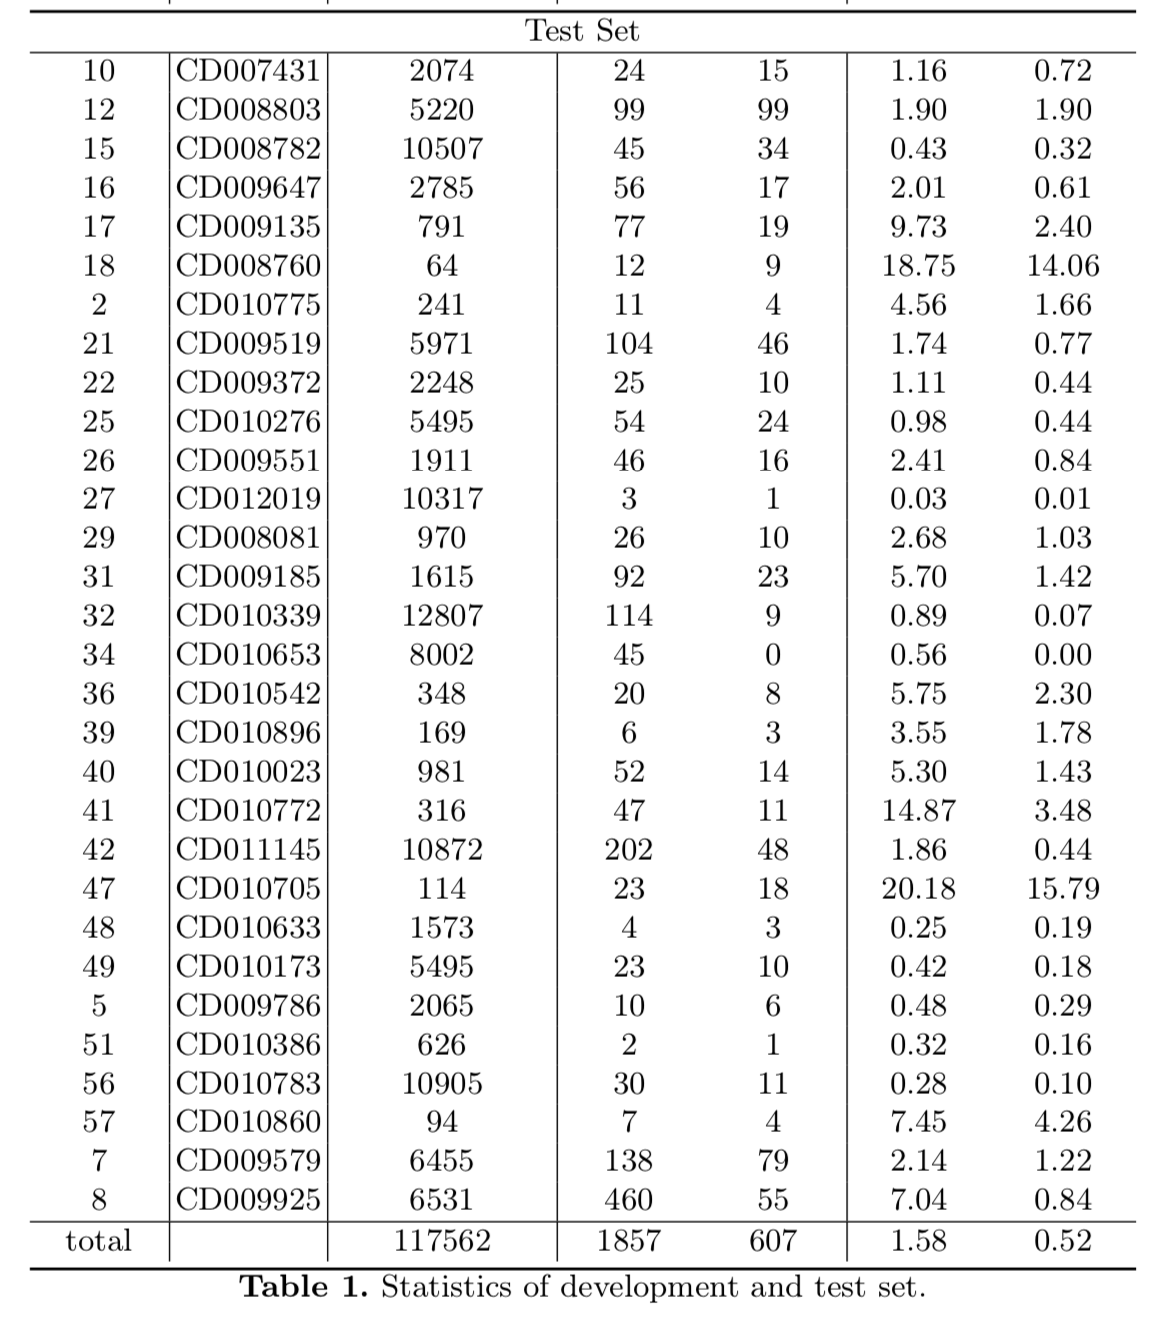

In [15]:
Image(filename='./images/table1.png', width=500)

# Results in [2]
- The results of Autotar and Knee are generated from the Waterloo runs in the CLEF TAR 2017 track.


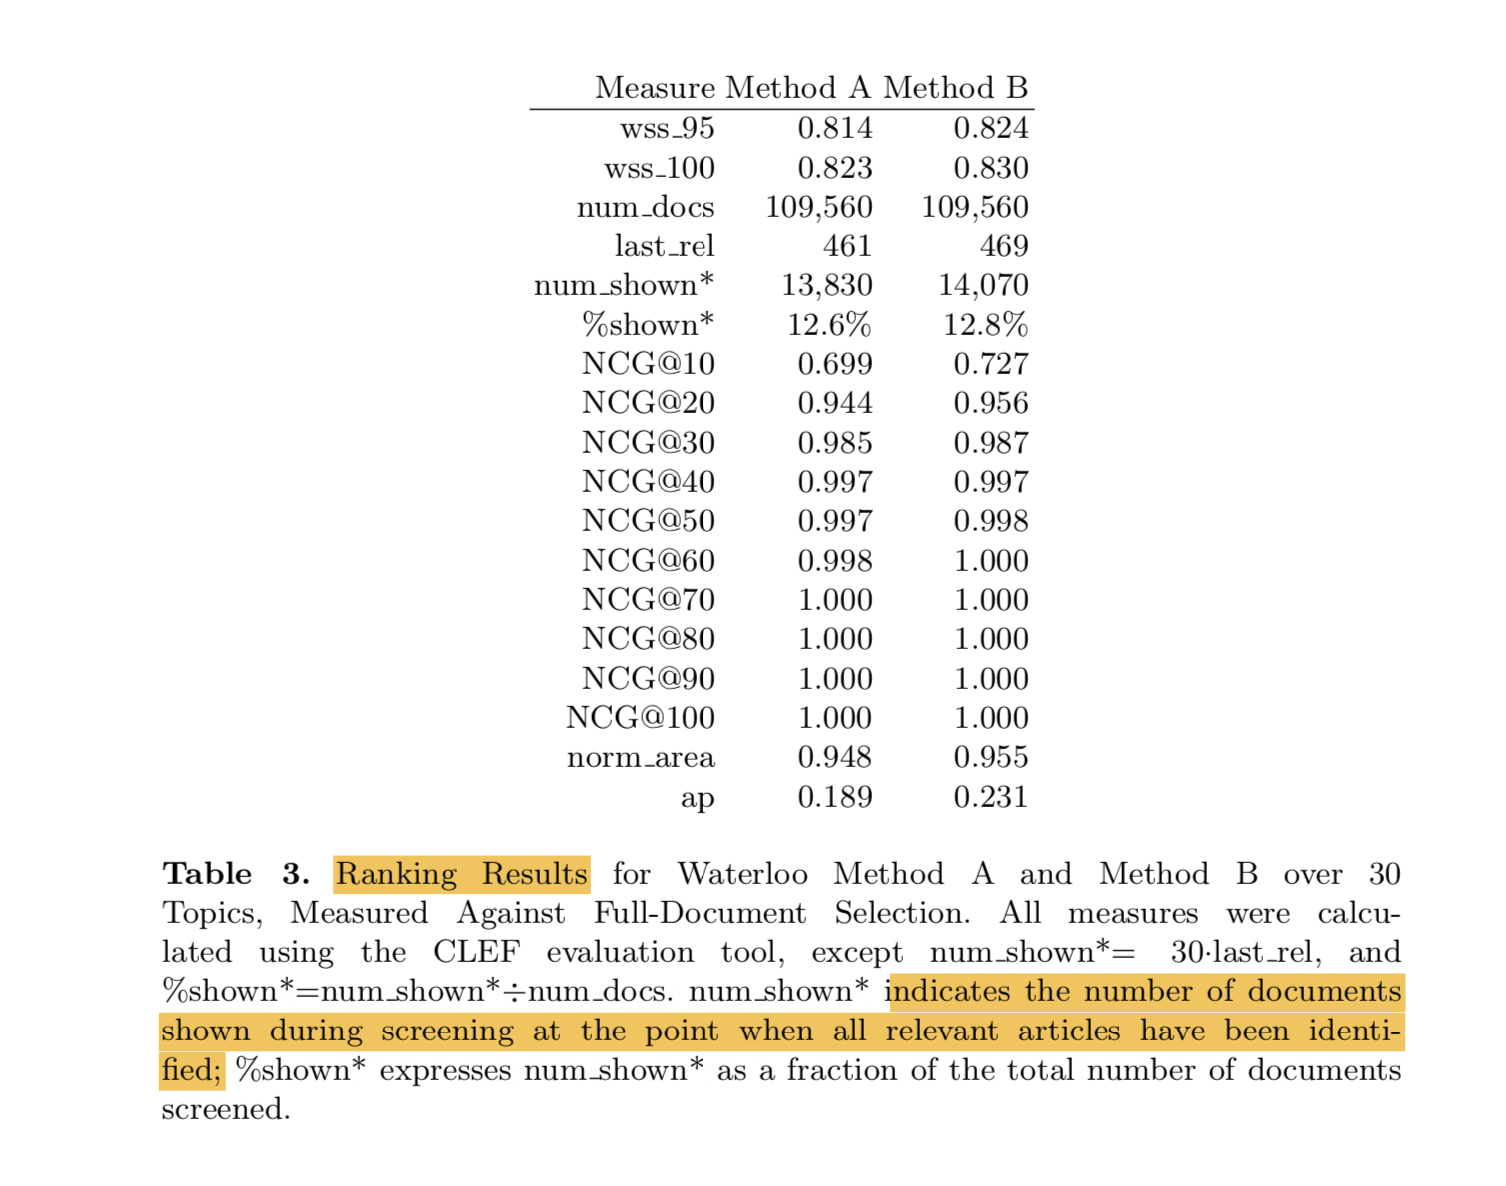

In [4]:
Image(filename='./images/waterloo_table3.png', width=500)

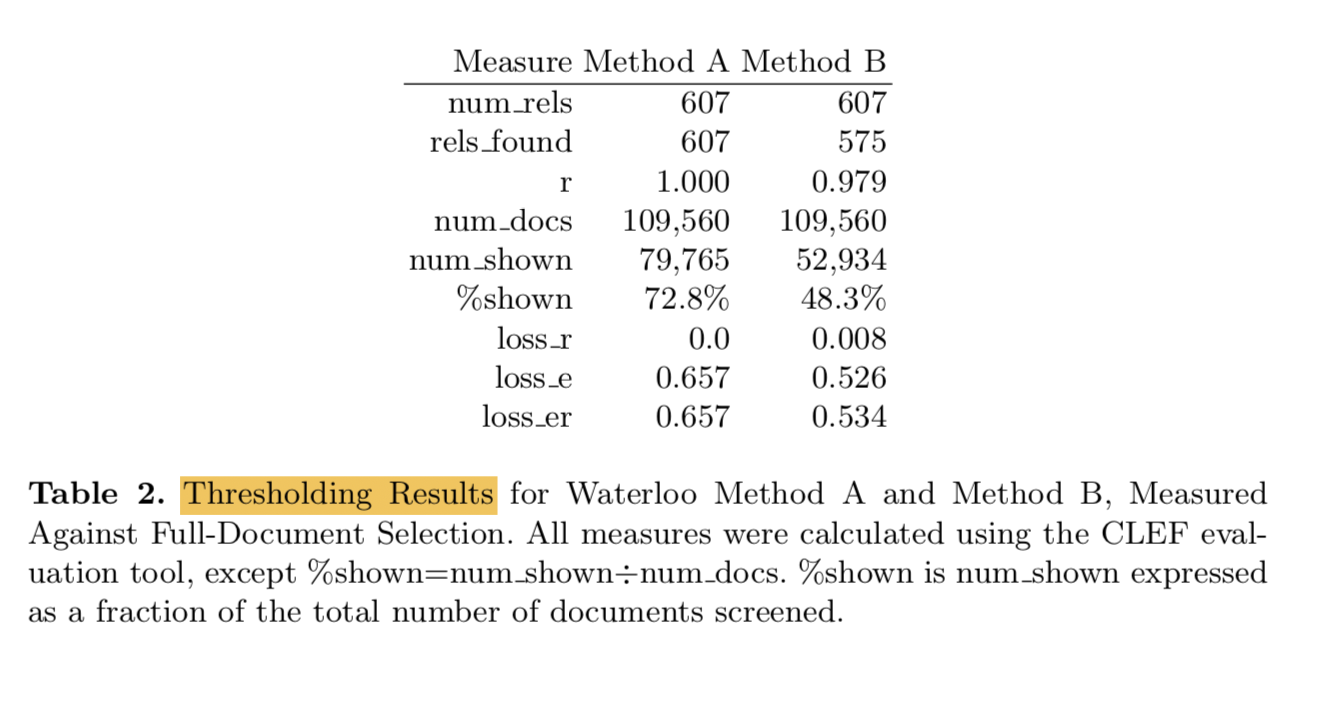

In [3]:
Image(filename='./images/waterloo_table2.png', width=500)

# Reproduce AutoTAR  and  Knee 
- We reproduce the **method A version** (which uses abstract-level relevance labels) described in the paper [2].
    
- We sweep hyper-parameters in order to reproduce the autotar and knee methods as close as possible.
    - **corpus**: the corpus used to construct word-representations for each document, it can be either the documents of the complete 30 topics or only the current topic.
    - **min_df**: minimum word frequency, it can be either 2, 3, or 5.
    - **C**: the weight of regularization for the logistic regression model.


In [11]:
def create_all_run(model_type='autotar'):
    for root, dirs, files in list(os.walk(ret_dir)):
        if model_type not in root:
            continue

        runfile = root+'/all.run'

        if len([file for file in files if 'CD' in file]) == 30:
            # creat all.run
#             print('Creating', runfile)
            try:
                os.remove(runfile)
            except:
                pass

            with open(runfile, 'w') as f:
                for file in files:
                    with open(root+'/'+file) as fr:
                        f.write(fr.read())
                        
    return

def load_all_run(model_type='autotar'):
    data = []

    for root, dirs, files in list(os.walk(ret_dir)):
        if model_type not in root:
            continue

        if len([file for file in files if 'CD' in file]) == 30:

            if 'all.run' not in files:
                print('all.run does not exists.')

            # tar_eval
            script = os.path.join(tar_master_dir, 'scripts/tar_eval.py')
            qrelfile = os.path.join(tar_master_dir, '2017-TAR/testing/qrels/qrel_content_test.txt')
            runfile = root+'/all.run'
            ret = subprocess.check_output(['python', script, qrelfile, runfile])


            # parse result
            ret = subprocess.check_output([' tail -27 '], shell=True, input=ret)
            ret = ret.decode(encoding='utf-8')

            dct = {}
            for line in ret.split('\n'):

                if line != '':
                    topic_id, key, val = line.split()
                    dct[key] = float(val)


            folder = root[:-2]

            expid = os.path.basename(root)
            ct = re.findall('_ct.*_', folder)[0]
            md = re.findall('md.*_', folder)[0]
            c = re.findall('c\d+\.{0,1}\d+', folder)[0]

            lst = [expid, ct, md, c]
            for key in dct:
                lst.append(dct[key])

            data.append(lst)

    head = ['expid', 'ct', 'md', 'c' ] + list(dct.keys())
    
    df = pd.DataFrame(data=data, columns=head)
    
    df = df.groupby(['ct', 'md', 'c']).mean()
    
    return df


## Result of AutoTAR
- The result is close to Table 3. 
- We report metrics that are also reported in [2], they are ap – average precision, norm_area – area under the cumulative recall curve normalized by the optimal area, and last_rel – minimum number of documents returned to retrieve all relevant documents. With the best configuration we achieve an ap score of 0.191, an norm_area score of 0.947, and an last_rel score of 493, and the metrics are 0.189, 0.948 and 461 reported in [2]. We use the same configuration for all the latter methods.

In [14]:
df = load_all_run('autotar')

In [15]:
df[['ap', 'norm_area','last_rel']]

ap  norm_area    last_rel
ct                   md   c                                        
_ctclef2017test_md2_ md2_ c1.0      0.185000   0.937333  498.431167
_cttopicwise_md2_    md2_ c0.0001   0.188167   0.944833  431.166667
                          c1.0      0.192000   0.946500  448.155333
                          c10000.0  0.170667   0.937833  804.925167
_cttopicwise_md3_    md3_ c1.0      0.185667   0.945500  446.850667
_cttopicwise_md5_    md5_ c1.0      0.177667   0.942167  439.201167

## Result of Knee
- The result is close to Table 2.
- Similar to AutoTAR, we also swept over all possible configurations of the ranking model. The best configuration is the same with that of AutoTAR. With the best configuration (`C = 1.0, min_df = 2, corpus = topicwise`) we achieve an loss_er score of 0.610 and an recall score of 0.999, and the metrics are 0.657, 1.000, reported in [2].


In [12]:
df = load_all_run('knee')

In [13]:
df[['num_rels', 'rels_found','r', 'num_docs', 'num_shown', 'loss_r', 'loss_e', 'loss_er']]

num_rels  rels_found         r  num_docs  \
ct                   md   c                                                    
_ctclef2017test_md2_ md2_ c1.0         607.0  606.000000  0.999500  109560.0   
_cttopicwise_md2_    md2_ c0.0001      607.0  605.500000  0.999500  109560.0   
                          c1.0         607.0  605.500000  0.999333  109560.0   
                          c10000.0     607.0  604.333333  0.998500  109560.0   
_cttopicwise_md3_    md3_ c1.0         607.0  605.500000  0.999333  109560.0   
_cttopicwise_md5_    md5_ c1.0         607.0  605.500000  0.999000  109560.0   

                                       num_shown  loss_r    loss_e   loss_er  
ct                   md   c                                                   
_ctclef2017test_md2_ md2_ c1.0      90350.833333     0.0  0.685667  0.685667  
_cttopicwise_md2_    md2_ c0.0001   89193.166667     0.0  0.674500  0.674667  
                          c1.0      89533.333333     0.0  0.676833  0.676833  
                          c10000.0  97485.000000     0.0  0.707667  0.707833  
_cttopicwise_md3_    md3_ c1.0      90782.166667     0.0  0.684500  0.684500  
_cttopicwise_md5_    md5_ c1.0      89416.666667     0.0  0.681000  0.681000